<a href="https://colab.research.google.com/github/mingd00/Face-Recognition/blob/main/Notebooks/EfficientNet(with_FER).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNet 모델을 활용한 FER 데이터 학습



### 0. 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import cv2

### 1. 모델 로드

- 모델 기본 구조 확인

In [2]:
# 모델 로드 (ImageNet 가중치 사용)
model = EfficientNetB0(weights='imagenet', include_top=True)

# 모델 구조 출력
model.summary()

21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 5,330,571 (20.33 MB)

 Trainable params: 5,288,548 (20.17 MB)

 Non-trainable params: 42,023 (164.16 KB)

- 모델 수정: 사전 학습된 가중치는 고정하고 새로운 출력 레이어만 학습

In [3]:
# 1. EfficientNetB0 로드 (사전 학습된 ImageNet 가중치 사용)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# 2. 모델 수정 (FER 데이터셋에 맞게 출력 레이어 조정)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # 공간 차원을 평균화하여 벡터로 변환
x = Dense(128, activation='relu')(x)  # 추가 Fully Connected Layer
predictions = Dense(7, activation='softmax')(x)  # FER 데이터셋의 7개 감정 클래스 출력

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 48, 48, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 48, 48, 3)      │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 48, 48, 3)      │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 49, 49, 3)      │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 24, 24, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 24, 24, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 24, 24, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 24, 24, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 24, 24, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 24, 24, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 4,172,419 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [4]:
# 3. 사전 학습된 가중치 잠금 (Feature Extraction)
for layer in base_model.layers:
    layer.trainable = False  # EfficientNet 가중치 고정

# 4. 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 2. FER 데이터 로드 및 준비

In [7]:
# FER 데이터셋 로드
data = pd.read_csv("fer2013.csv")

# 데이터 및 라벨 분리
pixels = data['pixels'].str.split(" ").tolist()  # 픽셀 데이터를 리스트로 변환
pixels = np.array(pixels, dtype='float32') / 255.0  # 정규화
pixels = pixels.reshape(-1, 48, 48, 1)  # 48x48 그레이스케일 이미지 형태로 변환
pixels = np.repeat(pixels, 3, axis=-1)  # 그레이스케일 이미지를 3채널로 확장 (EfficientNet 입력 요구사항)

labels = to_categorical(data['emotion'], num_classes=7)

# 학습/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(pixels, labels, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((28709, 48, 48, 3), (7178, 48, 48, 3), (28709, 7), (7178, 7))

### 3. 학습

In [8]:
# 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=32)

In [9]:
# 첫 번째 학습: Feature Extraction (사전 학습된 가중치 고정)
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_val) // 32
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/897 ━━━━━━━━━━━━━━━━━━━━ 73s 57ms/step - accuracy: 0.2389 - loss: 1.8305 - val_accuracy: 0.2461 - val_loss: 1.8143
Epoch 2/10
  1/897 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.2812 - loss: 1.7025

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2812 - loss: 1.7025 - val_accuracy: 0.1000 - val_loss: 1.7625
Epoch 3/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.2513 - loss: 1.8213 - val_accuracy: 0.2461 - val_loss: 1.8114
Epoch 4/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 0.1875 - loss: 1.8994 - val_accuracy: 0.1000 - val_loss: 1.8976
Epoch 5/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.2497 - loss: 1.8135 - val_accuracy: 0.2461 - val_loss: 1.8146
Epoch 6/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 39us/step - accuracy: 0.2812 - loss: 1.7323 - val_accuracy: 0.1000 - val_loss: 2.0566
Epoch 7/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.2511 - loss: 1.8117 - val_accuracy: 0.2457 - val_loss: 1.8170
Epoch 8/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 0.2188 - loss: 2.0048 - val_accuracy: 0.4000 - val_loss: 1.6648
Epoch 9/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.2535 - loss: 1.8132 - val_accuracy: 0.

In [52]:
# 두 번째 학습: Fine-Tuning (가중치 조정 가능하게 변경)
for layer in base_model.layers:
    layer.trainable = True  # EfficientNet 가중치 조정 가능하게 변경

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=30,
                    steps_per_epoch=len(X_train) // 32,
                    validation_steps=len(X_val) // 32
                    )

Epoch 1/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 147s 82ms/step - accuracy: 0.5588 - loss: 1.1709 - val_accuracy: 0.5788 - val_loss: 1.1321
Epoch 2/30
  1/897 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.4688 - loss: 1.2889

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4688 - loss: 1.2889 - val_accuracy: 0.8000 - val_loss: 0.9534
Epoch 3/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - accuracy: 0.5829 - loss: 1.1041 - val_accuracy: 0.5812 - val_loss: 1.1092
Epoch 4/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step - accuracy: 0.6875 - loss: 1.1406 - val_accuracy: 0.5000 - val_loss: 1.2212
Epoch 5/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.5956 - loss: 1.0744 - val_accuracy: 0.5851 - val_loss: 1.1153
Epoch 6/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - accuracy: 0.7188 - loss: 0.9677 - val_accuracy: 0.6000 - val_loss: 1.0285
Epoch 7/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 48s 53ms/step - accuracy: 0.6131 - loss: 1.0367 - val_accuracy: 0.5903 - val_loss: 1.0944
Epoch 8/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30us/step - accuracy: 0.6250 - loss: 0.9053 - val_accuracy: 0.8000 - val_loss: 0.6391
Epoch 9/30
897/897 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.6256 - loss: 0.9956 - val_accuracy: 0

### 4. 모델 평가

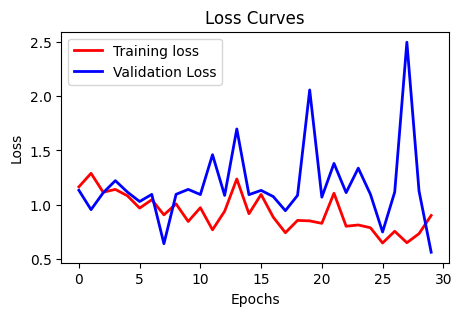

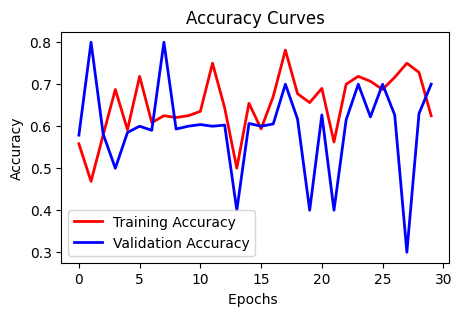

In [53]:
# 손실 함수
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

# 정확도
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs ')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

plt.show()

### 5. 모델 저장 및 호출

In [ ]:
model.save("fer_efficientnetb0.h5")

### 5. 예측

In [58]:
img_path = 'img2.jpg'  # 이미지 파일 경로
img = image.load_img(img_path, target_size=(48, 48))  # EfficientNetB0의 입력 크기로 맞춤
img_array = image.img_to_array(img)  # 이미지를 numpy 배열로 변환
img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가
img_array = img_array / 255.0  # 이미지 정규화 (0~1 사이로)
img_array

array([[[[0.10980392, 0.17254902, 0.16862746],
         [0.16862746, 0.2       , 0.20784314],
         [0.13725491, 0.1764706 , 0.17254902],
         ...,
         [0.10588235, 0.10196079, 0.08627451],
         [0.05098039, 0.03529412, 0.02352941],
         [0.04705882, 0.04313726, 0.03529412]],

        [[0.19215687, 0.23529412, 0.25882354],
         [0.21176471, 0.23921569, 0.2784314 ],
         [0.22352941, 0.24313726, 0.25490198],
         ...,
         [0.11372549, 0.09803922, 0.08627451],
         [0.0627451 , 0.04705882, 0.03529412],
         [0.05882353, 0.04313726, 0.03137255]],

        [[0.18431373, 0.24313726, 0.27058825],
         [0.22352941, 0.25882354, 0.2784314 ],
         [0.19607843, 0.21568628, 0.22745098],
         ...,
         [0.09411765, 0.07843138, 0.06666667],
         [0.06666667, 0.05098039, 0.03921569],
         [0.07450981, 0.05882353, 0.04705882]],

        ...,

        [[0.27058825, 0.21176471, 0.19215687],
         [0.23137255, 0.21176471, 0.1882353 ]

In [59]:
pred = model.predict(img_array)

# 감정 라벨
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# 각 클래스별 확률 출력
for i, label in enumerate(emotion_labels):
    print(f"{label}: {pred[0][i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Angry: 0.1109
Disgust: 0.0002
Fear: 0.0811
Happy: 0.0624
Sad: 0.5546
Surprise: 0.0151
Neutral: 0.1758


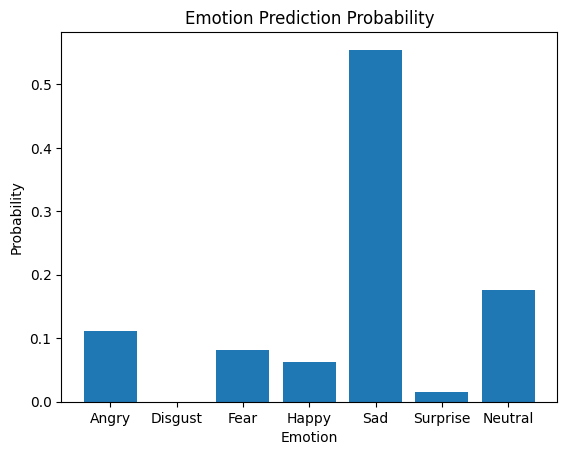

In [60]:
# 확률 값 시각화
plt.bar(emotion_labels, pred[0])
plt.xlabel('Emotion')
plt.ylabel('Probability')
plt.title('Emotion Prediction Probability')
plt.show()